# Networking graph analysis among twitter users 

Twitter users usually interact through replies, retweets, and quoted tweets. These interactions between the users are used for inferring the influential users and for community detection.  

### [Table of Contents](#cell2)

* 1\. [Creating interactions graph](#cell1)
* 2\.     - [Influential users using PageRank algorithm](#cell2)
    * 2.1. [Visualizing the interactions graph](#cell21)
* 3\. [Community detection using Louvain algorithm](#cell3)
    * 3.1. [Visualizing communities](#cell31)

In [33]:
import collections as col

import numpy as np
import pandas as pd

# visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.offline import iplot, plot
import matplotlib.cm as cm

# graph analysis
import networkx as nx
import community as community_louvain

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
BASE_PATH = '/Users/anshu/Work/Code/rpm-v2/data/v2/'

##### Loading the processed Singapore-based data 

In [36]:
sg_tweets = pd.read_csv(BASE_PATH + "sg.csv")
sg_tweets.shape

(181423, 54)

## 1. Creating interactions graph <a id="cell1"></a>
##### A directed weighted graph of interactions - replies, retweets, and quoted tweets between the users. 
##### The weights denote the number of interactions between two users.

In [37]:
sg_users = set() 
retweeted_users = set()
quoted_users = set()
replied_users = set()

for u in sg_tweets['user_screenname_x']: # merged csvs created user_screenname_x and user_screenname_y
    sg_users.add(u)
print("Count unique SG users: ", len(sg_users))

for u in sg_tweets[sg_tweets['replied_to_user_screenname'].notna()]['replied_to_user_screenname']: 
    if u == u:  replied_users.add(u)
print("Count unique replied users: ", len(replied_users))

for u in sg_tweets[sg_tweets['retweeted_user_screenname'].notna()]['retweeted_user_screenname']: 
    if u == u: retweeted_users.add(u)
print("Count unique retweeted users: ", len(retweeted_users))

for u in sg_tweets[sg_tweets['quoted_user_screenname'].notna()]['quoted_user_screenname']: 
    if u == u:  quoted_users.add(u)
print("Count unique quoted users: ", len(quoted_users))

Count unique SG users:  22531
Count unique replied users:  10458
Count unique retweeted users:  16999
Count unique quoted users:  7647


In [38]:
all_interacting_users = set.union(sg_users, replied_users, retweeted_users, quoted_users)
print("{} total unique interacting users".format(len(all_interacting_users)))

49459 total unique interacting users


In [39]:
common_interacting_users = set.intersection(sg_users, retweeted_users)
print("{} total unique common interacting users".format(len(common_interacting_users)))

1388 total unique common interacting users


### Creating directed graph with nodes, edges and weights 

Graph: Users' interaction through replies, retweets and quotes
- Nodes: Username
- Edge: From a user replying/retweeting/quoting to the author of the replyid/retweeted/quoted tweet
- Weight: Number of interactions between any two users 

In [40]:
G = nx.MultiDiGraph()
G.add_nodes_from(all_interacting_users)

interacting_edges = dict() # try set as well

# replies interaction
replies_sg = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Reply'][['user_screenname_x', 'replied_to_user_screenname']]
for user, iuser in zip(replies_sg['user_screenname_x'], replies_sg['replied_to_user_screenname']):
    if user and iuser and (user != iuser): 
        if (user, iuser,) in interacting_edges:
            interacting_edges[(user, iuser,)] += 1
        else:
            interacting_edges[(user, iuser,)] = 1
    
# retweets interaction
retweets_sg = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Retweet'][['user_screenname_x', 'retweeted_user_screenname']]
for user, iuser in zip(retweets_sg['user_screenname_x'], retweets_sg['retweeted_user_screenname']):
    if user and iuser and (user != iuser):  
        if (user, iuser,) in interacting_edges:
            interacting_edges[(user, iuser,)] += 1
        else:
            interacting_edges[(user, iuser,)] = 1
        
        
# quotes interaction
quotes_sg = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Quote'][['user_screenname_x', 'quoted_user_screenname']]
for user, iuser in zip(quotes_sg['user_screenname_x'], quotes_sg['quoted_user_screenname']):
    if user and iuser and (user != iuser):  
        if (user, iuser,) in interacting_edges:
            interacting_edges[(user, iuser,)] += 1
        else:
            interacting_edges[(user, iuser,)] = 1

weighted_interacting_edges_ = set()
for k, v in interacting_edges.items():
    weighted_interacting_edges_.add(k + (v,))
            
G.add_weighted_edges_from(weighted_interacting_edges_)

In [41]:
degrees = [val for (node, val) in G.degree()]
print("The maximum degree of the graph is " + str(np.max(degrees))) 
print("The minimum degree of the graph is " + str(np.min(degrees)))
print("There are " + str(G.number_of_nodes()) + " nodes and " + str(G.number_of_edges()) + " edges present in the graph")
print("The average degree of the nodes in the graph is " + str(np.mean(degrees)))

The maximum degree of the graph is 1350
The minimum degree of the graph is 0
There are 49460 nodes and 72608 edges present in the graph
The average degree of the nodes in the graph is 2.936029114435908


## 2. Influential users using PageRank algorithm <a id="cell2"></a>
#### Applied PageRanking on interactions graph to get the top 50 users

In [42]:
ranked_users = nx.pagerank(G, 0.9)
ranked_users = dict(sorted(ranked_users.items(), key=lambda item: item[1], reverse=True))

##### Top influential users 

In [43]:
top_x = 50
top_ranking = list(ranked_users)[:top_x]
top_ranking[:25]

['ChannelNewsAsia',
 'MothershipSG',
 'straits_times',
 'TODAYonline',
 'STForeignDesk',
 'JustinOngTODAY',
 'leehsienloong',
 'VP',
 'MatthewMohanCNA',
 'CherylLinCNA',
 'AqilHaziqCNA',
 'gayaCNA',
 'historyogi',
 'AlifAmsyarCNA',
 'LinXuelingCNA',
 'PichayadaCNA',
 'in_transitiverb',
 'sporeMOH',
 'HweeMinCNA',
 'lustfuldesirer',
 'muttons',
 'Tan_Hui_Yee',
 'LeongWaiKitCNA',
 'asonofapeach',
 'VivianBala']

#### Quality check of the ranking algorithm

The number of verified users in the top X rankings as the quality check of the ranking algo.


In [44]:
sg_verified_users =  sg_tweets[sg_tweets['user_verified'] == True]['user_screenname_x']
rt_verified_users = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet') & (sg_tweets['retweeted_user_verified'] == True)]['retweeted_user_screenname']
q_verified_users = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & (sg_tweets['quoted_user_verified'] == True)]['quoted_user_screenname']    

all_verified_users = set(list(sg_verified_users) + list(rt_verified_users) + list(q_verified_users))

In [45]:
z = set(top_ranking).intersection(all_verified_users) 
print("The number of verified users in the top {} rankings - {}%".format( top_x, len(z)/top_x*100))

The number of verified users in the top 50 rankings - 70.0%


### 2.1. Visualizing the interactions graph  <a id="cell21"></a>



#### Pruning the graph with low degree - Users who recieve low number of interactions 

In [47]:
G3 = G.copy() # creating a deep copy of the original graph 

In [106]:
G = G3.copy()

In [107]:
MIN_DEGREE_TO_HAVE = 100

low_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree < MIN_DEGREE_TO_HAVE]
print("Number of users to be removed with degree less than {}: {}".format( MIN_DEGREE_TO_HAVE, len(low_degree_nodes)))

Number of users to be removed with degree less than 100: 49363


In [108]:
G.remove_nodes_from(low_degree_nodes)
G.size(), G.order()

(300, 97)

#### Plotting the interactions graph with the Fruchterman-Reingold layout algorithm. 

In [109]:
pos = nx.fruchterman_reingold_layout(G)

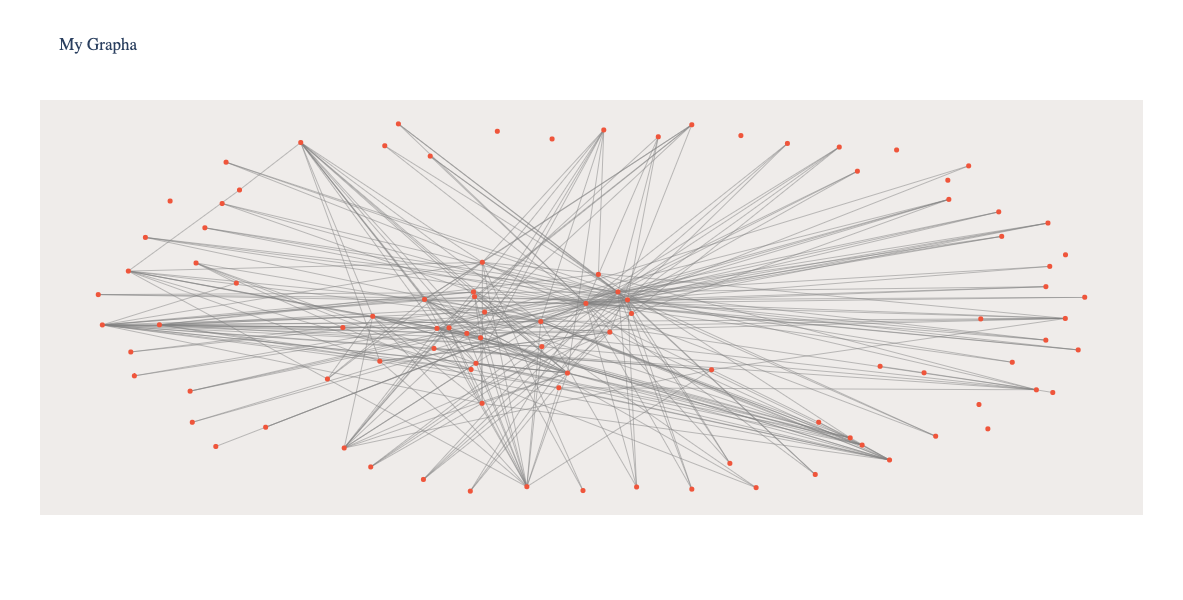

In [110]:
edge_x = []
edge_y = []
names = []
for edge in G.edges():
    x_gen_pos = pos[edge[0]]
    y_gen_pos = pos[edge[1]]
    edge_x.extend([x_gen_pos[0], y_gen_pos[0], None])
    edge_y.extend([x_gen_pos[1], y_gen_pos[1], None])
    
node_x = []
node_y = []

for node in G.nodes():
    gen_pos = pos[node]
    node_x.append(gen_pos[0])
    node_y.append(gen_pos[1])
    names.append(node)
    
trace_nodes=dict(type="scatter",
                 x=node_x, 
                 y=node_y,
                 mode="markers",
                 marker=dict(size=5, colorscale='YlGnBu'),
                 text=names,
                 hoverinfo="text")

trace_edges=dict(type="scatter",                  
                 mode="lines",                  
                 x=edge_x,                  
                 y=edge_y,                 
                 line=dict(width=0.5, color='grey'), hoverinfo="none")

axis=dict(showline=False, 
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=""
          )

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

layout=dict(title= "My Grapha",  
             font= dict(family="Balto"),
             width=600,
             height=600,
             autosize=False,
             showlegend=False,
             xaxis=axis,
             yaxis=axis,
             margin=dict(
             l=40,
             r=40,
             b=85,
             t=100,
             pad=0,   
     ),
     hovermode="closest",
     plot_bgcolor="#EFECEA", #set background color            
     )

fig = dict(data=[trace_edges, trace_nodes], layout=layout)

node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

iplot(fig)

## 3. Community detection using Louvain algorithm (modularity/partition)<a id="cell3"></a>

In [111]:
degrees = [val for (node, val) in G.degree()]
print("The maximum degree of the graph is " + str(np.max(degrees))) 
print("The minimum degree of the graph is " + str(np.min(degrees)))
print("There are " + str(G.number_of_nodes()) + " nodes and " + str(G.number_of_edges()) + " edges present in the graph")
print("The average degree of the nodes in the graph is " + str(np.mean(degrees)))

The maximum degree of the graph is 37
The minimum degree of the graph is 0
There are 97 nodes and 300 edges present in the graph
The average degree of the nodes in the graph is 6.185567010309279


### 3.1. Visualizing communities<a id="cell31"></a>

In [112]:
# coverting to directed graph 
G2 = G.to_undirected()

In [113]:
partition = community_louvain.best_partition(G2)
pos_2 = nx.spring_layout(G2)

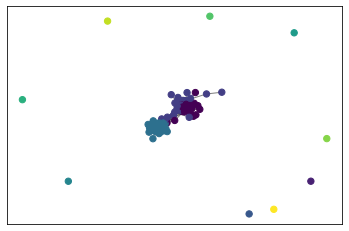

In [114]:
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G2, pos_2, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos_2, alpha=0.5)
plt.show()

In [105]:
clusters = col.defaultdict(int)
for k, v in partition.items():
    clusters[v] += 1
clusters = {k: v for k, v in sorted(clusters.items(), key=lambda item: item[1], reverse=True)}